In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances
import numpy as onp
import jax.numpy as np
from jax import jit, vmap
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as t
from ipywidgets import interact
from jax import grad
from jax.scipy.optimize import minimize
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax.scipy.linalg import cholesky, cho_factor, cho_solve
from jax.scipy.optimize import minimize
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_box

import pandas as pd

In [2]:
PCANet = pd.read_csv("data/PCA_Solid.csv", header = None).to_numpy()
DeepONet = pd.read_csv("data/DeepONet_Solid.csv", header = None).to_numpy()
Para = pd.read_csv("data/PARA_Solid.csv", header = None).to_numpy()
FNO = pd.read_csv("data/FNO_Solid.csv", header = None).to_numpy()

In [3]:
np.min(PCANet[:,4]), np.min(FNO[:,4]), np.min(DeepONet[:, 4]), np.min(Para[:, 4])

(DeviceArray(0.04670721, dtype=float64),
 DeviceArray(0.04765377, dtype=float64),
 DeviceArray(0.05201438, dtype=float64),
 DeviceArray(0.04550915, dtype=float64))

In [4]:
#Structural Mechanics

In [5]:
Inputs = np.load('data/StructuralMechanics_inputs.npy')
Outputs = np.load('data/StructuralMechanics_outputs.npy')

In [6]:
Inputs = Inputs[:,0,:]

In [7]:
#Inputs = Inputs.transpose((2,1,0))
Outputs = Outputs.transpose((2,1,0))
Inputs_fl = Inputs.T.reshape(len(Inputs.T), 41)
Outputs_fl = Outputs.reshape(40000, 41*41)

In [8]:
Ntrain = 20000
Xtr = Inputs_fl[:Ntrain]
Ytr = Outputs_fl[:Ntrain]
Xtest = Inputs_fl[20000:]
Ytest = Outputs_fl[20000:]

In [9]:
def sqeuclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sum( (x - y) ** 2)
dists = jit(vmap(vmap(sqeuclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))

def euclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.sum( (x - y) ** 2))
sqdists = jit(vmap(vmap(euclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))


@jit
def matern(v1, v2, sigma = 50):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = sqdists(v1, v2)
    #return a*np.exp(-d**2/sigma)
    return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)

@jit
def exp(v1, v2, sigma):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = dists(v1, v2)
    return np.exp(-d/sigma)
    #return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)

@jit
def iq(v1, v2, sigma):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = dists(v1, v2)
    #return a*np.exp(-d**2/sigma)
    #return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)
    return 1/np.sqrt(d+sigma)

In [10]:
def aux(kernel, s, nugget):
    k = kernel
    Kxx = k(Xtr, Xtr, s)
    nuggeted_matrix = Kxx.at[np.diag_indices_from(Kxx)].add(nugget)
    L = cho_factor(nuggeted_matrix)
    result = cho_solve(L, Ytr)
    Train_pred = Kxx@result #train predictions
    K_te_tr = k(Xtest, Xtr,s)
    Test_pred = K_te_tr@result #test predictions

    np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))

    aux1 = np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))
    aux2 = np.mean(np.linalg.norm(Train_pred-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
    aux3 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1))
    aux4 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1)/np.linalg.norm(Ytest, axis = 1))
    print(s, nugget)
    print("\n Train error (abs): {0} \n Train error (rel): {1} \n Test error (abs): {2} \n Test error (rel): {3}".format(aux1, aux2, aux3, aux4))
    print('---')

In [12]:
for kernel in [iq]:
    for s in [50000]:
        for nugget in [1e-8]:
            aux(kernel, s, nugget)

50000 1e-08

 Train error (abs): 0.0016342663422412745 
 Train error (rel): 3.011272706077225e-07 
 Test error (abs): 288.4922779165876 
 Test error (rel): 0.05185534694069363
---


In [13]:
Kxx = iq(Xtr, Xtr, 50000)
nuggeted_matrix = Kxx.at[np.diag_indices_from(Kxx)].add(nugget)
L = cho_factor(nuggeted_matrix)
result = cho_solve(L, Ytr)
Train_pred = Kxx@result #train predictions
K_te_tr = iq(Xtest, Xtr,50000)
Test_pred = K_te_tr@result #test predictions


In [14]:
import pickle

In [16]:
len(Ytest[42])

1681

In [29]:
pickle.dump(obj=[Ytest[41], Test_pred[41]], file = open('PredictedSM.pkl', 'wb'))

In [27]:
np.linalg.norm(Test_pred[41]-Ytest[41])/np.linalg.norm(Ytest[41])

DeviceArray(0.03921741, dtype=float64)

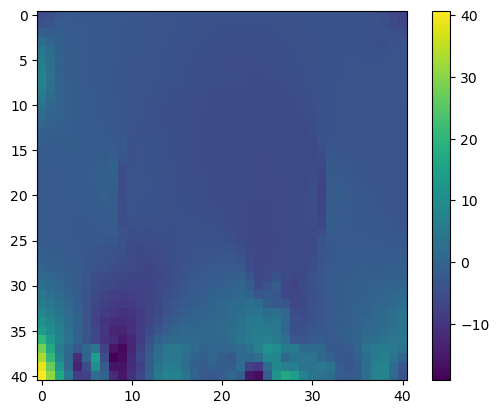

In [28]:
plt.imshow(Test_pred[41].reshape(41,41)-Ytest[41].reshape(41,41))
plt.colorbar()

In [14]:
grid = np.linspace(0,1,41)
K_i = exp(grid, grid, sigma = 0.001)
K_i = K_i.at[np.diag_indices_from(K_i)].add(1e-8)
L_K = cholesky(K_i, lower = True)
#K_o = exp(grid, grid, sigma = 3)
#K_o = K_i.at[np.diag_indices_from(K_i)].add(1e-8)
#L_G = cholesky(K_i, lower = False)
#L_G_inv = np.linalg.inv(L_G)


In [15]:
np.linalg.norm(L_K-np.eye(len(L_K)))

DeviceArray(4.02381579, dtype=float64)

In [21]:
Inputs2 = L_K@Inputs_fl.T
Outputs2 = Outputs_fl

Xtr = Inputs2.T[:Ntrain]
Ytr = Outputs2[:Ntrain]
Xtest = Inputs2.T[20000:]
Ytest = Outputs2[20000:]

In [22]:
for kernel in [iq]:
    for s in [100000]:
        for nugget in [1e-8]:
            aux(kernel, s, nugget)

100000 1e-08

 Train error (abs): 0.00253774259137323 
 Train error (rel): 4.6931449889152285e-07 
 Test error (abs): 289.6629104175087 
 Test error (rel): 0.052100366603367344
---
